# Processing, analysis, and visualization pipeline for correcting unwanted experiment-induced complex baseline changes and detecting and quantifying the largest event-related peaks in fMRI timeseries data.
## In this particular pipeline peak quantification is done seperately for the first and last 5 events in each session as a planned comparison

In [ ]:
%pylab inline
%load_ext autoreload
%autoreload 2
import pynit as pn #for reading BIDS heirarchical folder formatred projects
import pynsp as nsp # for ALS detrending
import os
import pandas as pd
import matplotlib.patches as patches
import matplotlib.ticker as ticker
from pynsp.methods import signal
from sklearn.linear_model import LinearRegression
from pandas import DataFrame
from pandas import date_range
from pandas import datetime
from matplotlib import pyplot
from datetime import timedelta  
from scipy.signal import find_peaks
from numpy import NaN
from numpy import asarray
from pandas import read_csv
from math import isnan
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
from matplotlib import pyplot, colors, rcParams 

rcParams['figure.dpi'] = 300
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Liberation Sans']

import warnings
warnings.filterwarnings("ignore")

# Plot formatting helper function

In [11]:
def tsplot(df, add_plot=None, figsize=None, xlim=None, ylim=None, xlabel=None, ylabel=None,
               label_size=None, tick_size=None, title=None, title_size=None, err=0, **kwargs):
        """

        :param df:
        :param figsize:
        :param xlim:
        :param ylim:
        :param xlabel:
        :param ylabel:
        :param label_size:
        :param tick_size:
        :param title:
        :param title_size:
        :param err: 0 = standard deviation, 1 = standard error
        :param kwargs:
        :return:
        """
        if not add_plot:
            fig, axes = plt.subplots(1,1,figsize=figsize)
        else:
            fig, axes = add_plot
        fig.patch.set_facecolor('white')
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        for axis in ['top','bottom','left','right']:
              axes.spines[axis].set_linewidth(5)
        if xlim:
            axes.set_xlim(xlim)
        if ylim:
            axes.set_ylim(ylim)
        if title:
            axes.set_title(title, size=title_size)
        if xlabel:
            axes.set_xlabel(xlabel, size=label_size)
        else:
            axes.set_xlabel('Time (s)', size=label_size)
        if ylabel:
            axes.set_ylabel(ylabel, size=label_size)
        else:
            axes.set_ylabel('Responses', size=label_size)
            
        tlen = int(tick_size/5)
        
        axes.tick_params(labelsize=tick_size, direction='out', top='off', right='off', width = 5, length = tlen)
        grey2 = [colors.to_rgba('grey',.1)]
        
        if err == 1:
            sns.tsplot(df.T.values, err_style='sterr_band', ax=axes,  **kwargs)
            
        elif err == 0:
            sns.tsplot(df.T.values, err_style=None, ax=axes, **kwargs)
        else:
            sns.tsplot(df.T.values, err_style='unit_traces', err_palette = grey2, err_kws = {'alpha':.15}, ax=axes, **kwargs)
        return fig, axes

# load BIDS format project object from parent directory
## This should point to project in a \project\subproject\group\dtype\ directory organization

In [ ]:
prj = pn.Project('project-directory-path') # load project object
prj.reload() # reload all updates
prj(2, ext=['.xlsx']).summary

# function to get group-level data from project object

In [3]:
def get_data_from_group(prj, group, region):
    new_prj = prj(2, 'subproject-folder-name', 'session-folder-name', group, ext='.xlsx')
    df = pd.DataFrame()
    for i, finfo in new_prj:
        df[i] = pd.read_excel(finfo.Abspath)[region]
    return df

# function to correct baseline drift by subtracting quantile regression line of best fit
## this is useful for within-session comparisons (e.g. first vs last) when peaks are all in the same direction

In [4]:
def flatten_data(y): # 0.9 quantile
    for name in y.columns:
        X = np.array(range(len(y[name]))).reshape(-1,1)
        Y = y[name].values.reshape(-1,1)
        exwi=pd.DataFrame(np.hstack([X,Y]), columns = ["x", "y"]) 

        mod = smf.quantreg('y ~ x',data=exwi)
        res= mod.fit(q=0.9) #change quantile here if needed

        slope = res.params['x']
        y_int = res.params['Intercept']

        for i in range(len(y[name])):
            y[name][i] = y[name][i] - (slope * i + y_int)

# function to baseline fit by asymmetric least squares (not straight line), baseline detrend, baseline substract, then plot group data mean +/- SEM for each session, including seperate plots with just or w/o the total baseline correction plotted for validation

# this particular function also include a marker for a second experimental manipulation (in this case a drug infusion affecting the event-related responses)

## Change veriables to fit your paradigm as needed here or when calling function, adjust lamda, p, and niter as needed to get a good ALS fit

In [51]:
# p should be approximately .0005 for positive, .9995 for negative ALS baseline fit then 0.9 quantile detrend
def plot_group_data(prj, group, region, lamda=20e3, p=0.9995, niter=20, figsize=[15,7.5], label_size=60, err=1, title_size=60, 
                    tick_size=50, ylabel='CBV change (%)', xlabel='', color1='tab:red', color2='tab:blue', bl_end=119, drug_start = 900, drug_dur = 600,
                    ylim=[-20, 20], ylim1 = [-5,25], ylim2 = [-20,5], n_tick_a=10, n_tick_a1 = 5, n_tick_a2 = 5, n_tick_b = 450, stim=[range(120, 180*15+120-1, 180), 60], linewidth = 5):
    data = get_data_from_group(prj, group, region)
    data_raw = get_data_from_group(prj, group, region)
    data_temp = get_data_from_group(prj, group, region) 

    n_subj = data_temp.shape[-1]
    data_temp1 = pd.DataFrame(map(signal.als_detrend, data_temp.T.values, [lamda]*n_subj, [p]*n_subj, [niter]*n_subj)).T

    flatten_data(data_temp1)
    
    dfup_sub = data_temp1.iloc[0:bl_end]
    data1 = data_temp1 - dfup_sub.mean()
     
    data1= data1*100
    baseline1 = data_raw*100 - data1
    line = 1-(data1/data1)
    
    print "Data from: " + data1.shape[1] + " trials"
    
    data1.to_excel('{}_{}_{}.xlsx'.format(group, region, 'events'), index=None, header=None)
    baseline1.to_excel('{}_{}_{}.xlsx'.format(group, region, 'baseline'), index=None, header=None)
    
    ax = tsplot(line, color = 'black', err=err, figsize=figsize,label_size=label_size, title_size=title_size,
                tick_size=tick_size, ylabel=ylabel, xlabel=xlabel, ylim=ylim, linewidth=linewidth)
    ax = tsplot(baseline1, color = color1, err=err, figsize=figsize,label_size=label_size, title_size=title_size,
                tick_size=tick_size, ylabel=ylabel, xlabel=xlabel, ylim=ylim, linewidth=linewidth, add_plot=ax)
    ax = tsplot(data1, color = color2, err=err, figsize=figsize,label_size=label_size, title_size=title_size,
                tick_size=tick_size, ylabel=ylabel, xlabel=xlabel, ylim=ylim, linewidth=linewidth, add_plot=ax)
    ax[1].yaxis.set_major_locator(ticker.MultipleLocator(n_tick_a))
    ylim_neg = ax[1].get_ylim()
    ax[1].set_xlim(right = data1.shape[0])
    ax[1].xaxis.set_major_locator(ticker.MultipleLocator(n_tick_b))
    if stim:
        for p in stim[0]:
            ax[1].add_patch(patches.Rectangle((p, ylim_neg[0]), stim[1], abs(ylim_neg[0])+abs(ylim_neg[1]),color='g', alpha=0.09))
    ax[1].add_patch(patches.Rectangle((drug_start, ylim_neg[0]), drug_dur, (abs(ylim_neg[0])+abs(ylim_neg[1]))*.05,color='tab:red', alpha=0.5))

    ax1 = tsplot(baseline1, color = color1, err=err, figsize=figsize,label_size=label_size, title_size=title_size,
                tick_size=tick_size, ylabel=ylabel, xlabel=xlabel, ylim=ylim1, linewidth=linewidth)

    ax1[1].yaxis.set_major_locator(ticker.MultipleLocator(n_tick_a1))
    ylim_neg1 = ax1[1].get_ylim()
    ax1[1].set_xlim(right = data1.shape[0])
    ax1[1].xaxis.set_major_locator(ticker.MultipleLocator(n_tick_b))
    if stim:
        for p in stim[0]:
            ax1[1].add_patch(patches.Rectangle((p, ylim_neg1[0]), stim[1], abs(ylim_neg1[0])+abs(ylim_neg1[1]),color='g', alpha=0.09))
    ax1[1].add_patch(patches.Rectangle((drug_start, ylim_neg1[0]), drug_dur, (abs(ylim_neg1[0])+abs(ylim_neg1[1]))*.05,color='tab:red', alpha=0.5))
    
    ax2 = tsplot(line, color = 'black', err=err, figsize=figsize,label_size=label_size, title_size=title_size,
                tick_size=tick_size, ylabel=ylabel, xlabel=xlabel, ylim=ylim2, linewidth=linewidth)
    ax2 = tsplot(data1, color = color2, err=err, figsize=figsize,label_size=label_size, title_size=title_size,
                tick_size=tick_size, ylabel=ylabel, xlabel=xlabel, ylim=ylim2, linewidth=linewidth, add_plot=ax2)
    ax2[1].yaxis.set_major_locator(ticker.MultipleLocator(n_tick_a2))
    ylim_neg2 = ax2[1].get_ylim()
    ax2[1].set_xlim(right = data1.shape[0])
    ax2[1].xaxis.set_major_locator(ticker.MultipleLocator(n_tick_b))
    if stim:
        for p in stim[0]:
            ax2[1].add_patch(patches.Rectangle((p, ylim_neg2[0]), stim[1], abs(ylim_neg2[0])+abs(ylim_neg2[1]),color='g', alpha=0.09))
    ax2[1].add_patch(patches.Rectangle((drug_start, ylim_neg2[0]), drug_dur, (abs(ylim_neg2[0])+abs(ylim_neg2[1]))*.05,color='tab:red', alpha=0.5)) 
    
    
    return ax, ax1, ax2

7


((<matplotlib.figure.Figure at 0x7f7e17967fd0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f7e15450850>),
 (<matplotlib.figure.Figure at 0x7f7e1464c590>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f7e1464cfd0>),
 (<matplotlib.figure.Figure at 0x7f7e152fef10>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f7e1530b810>))

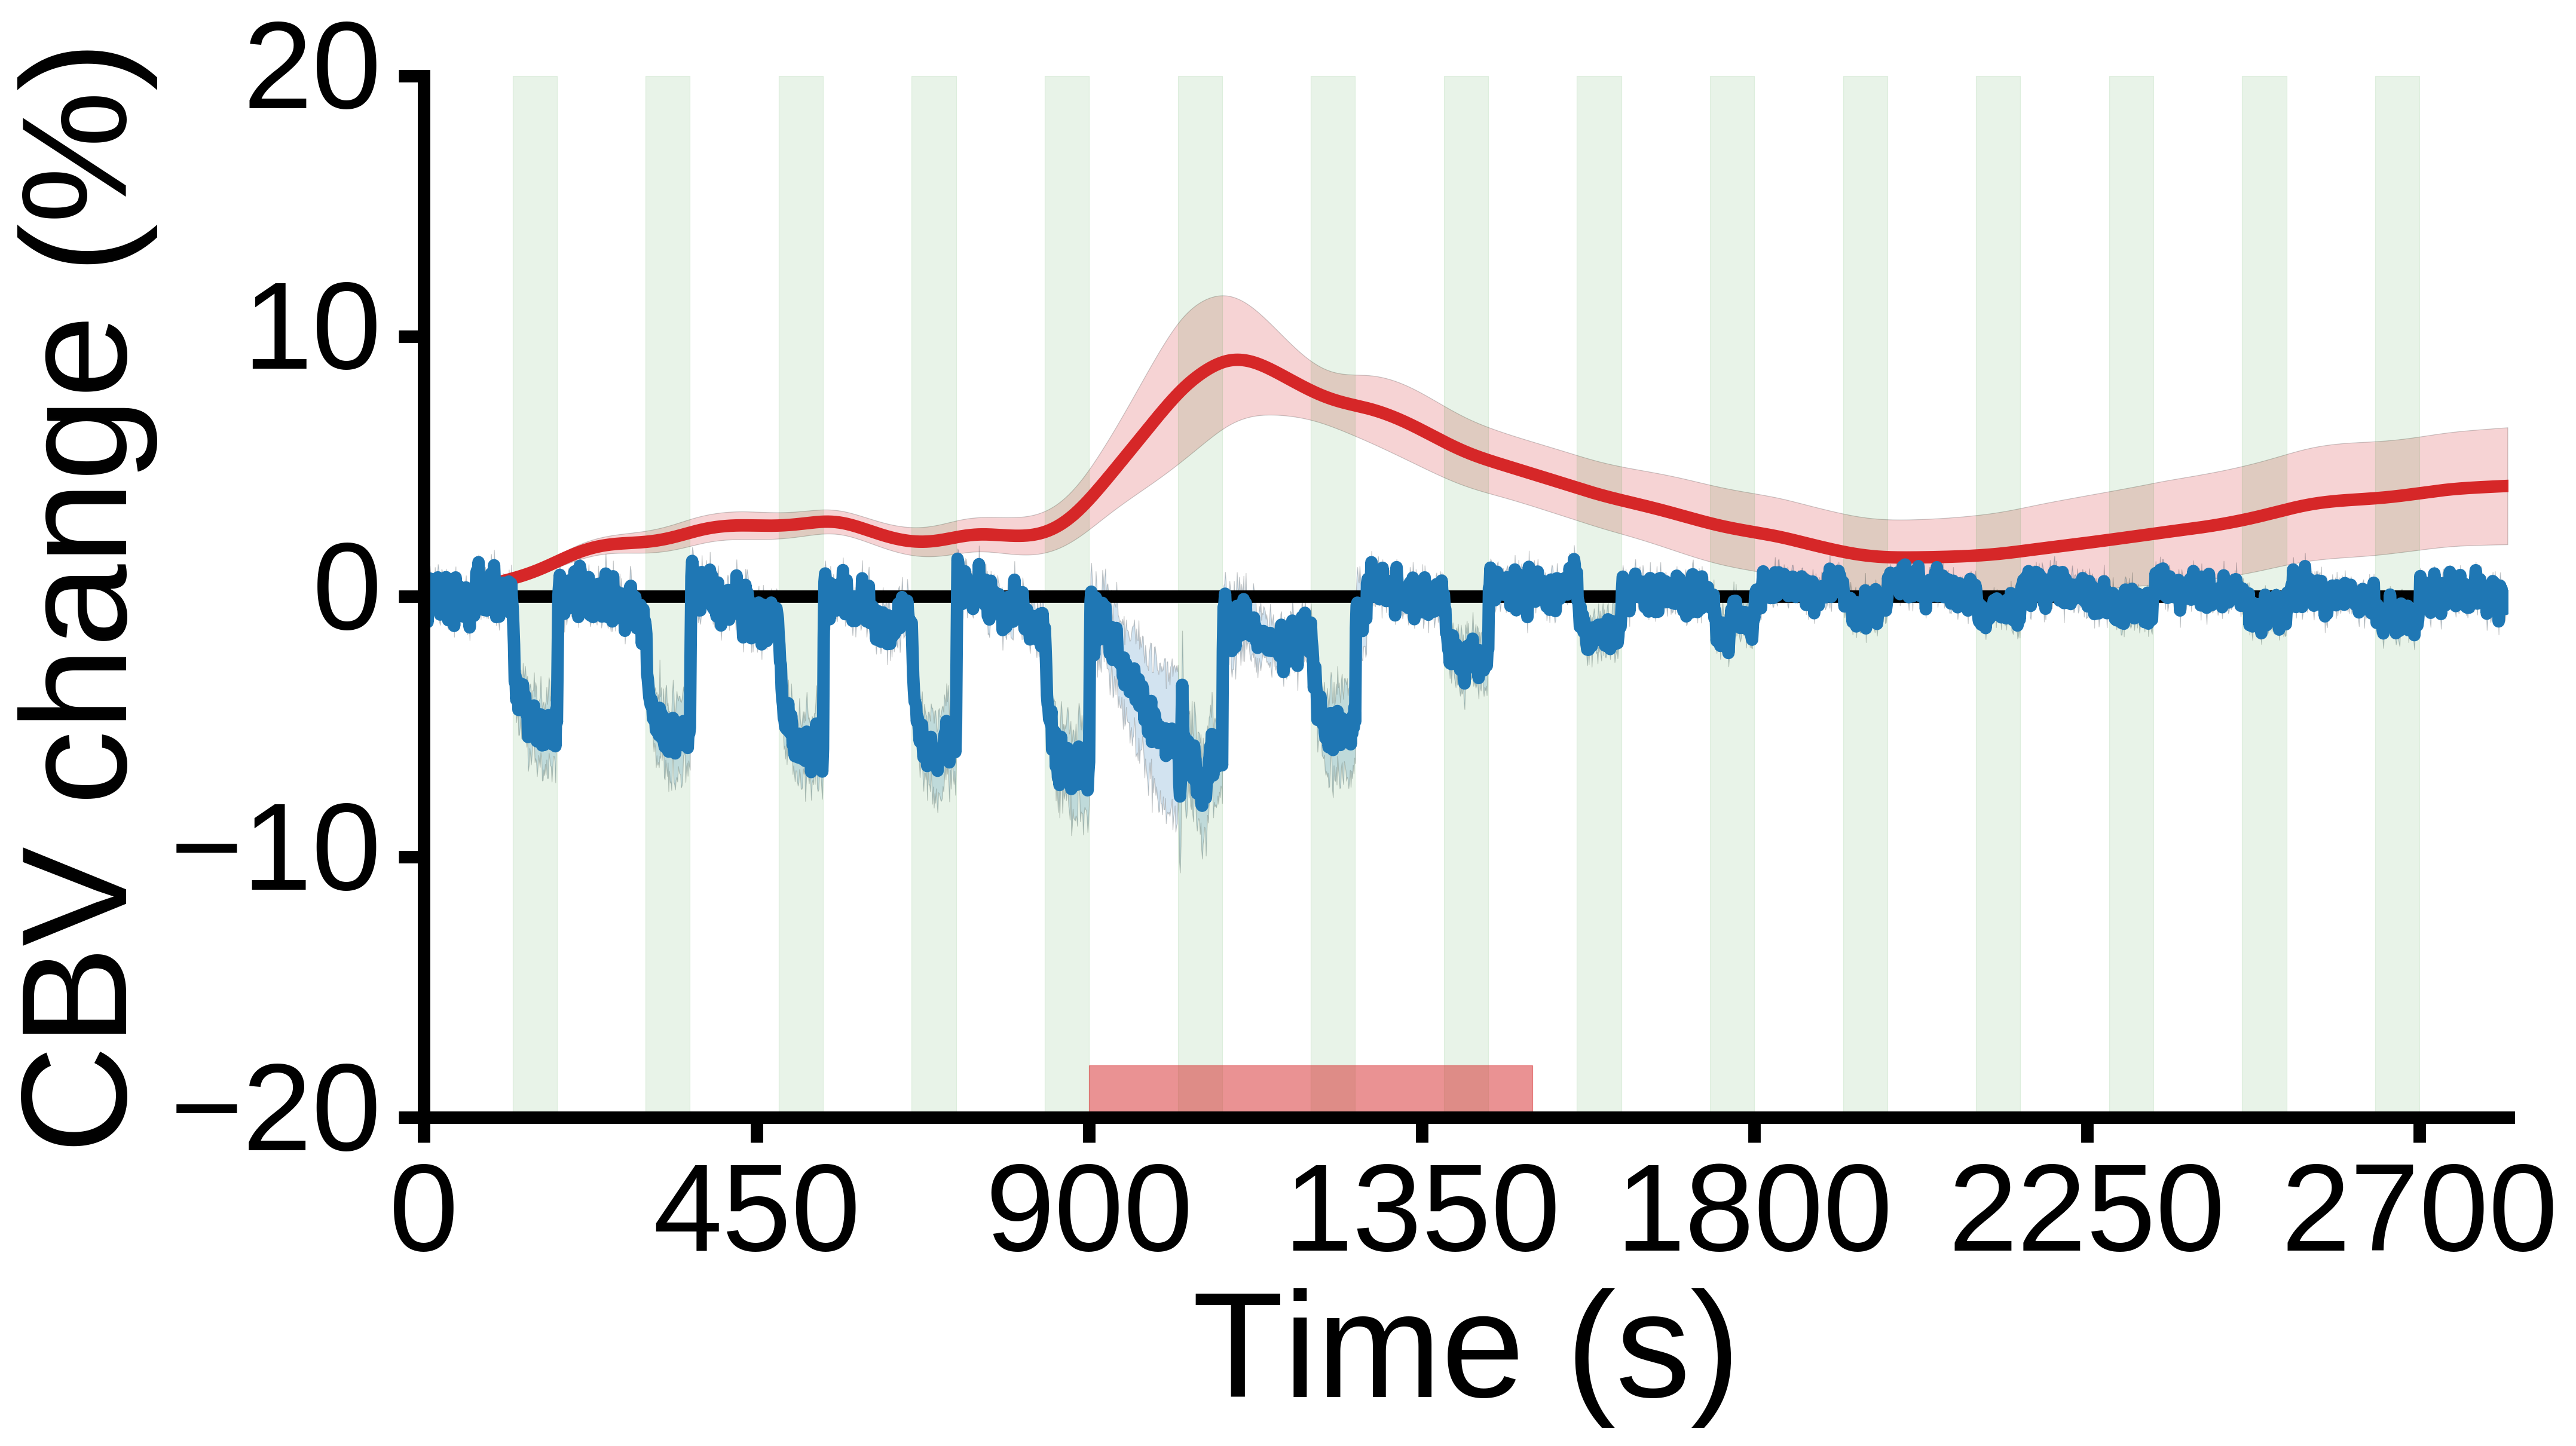

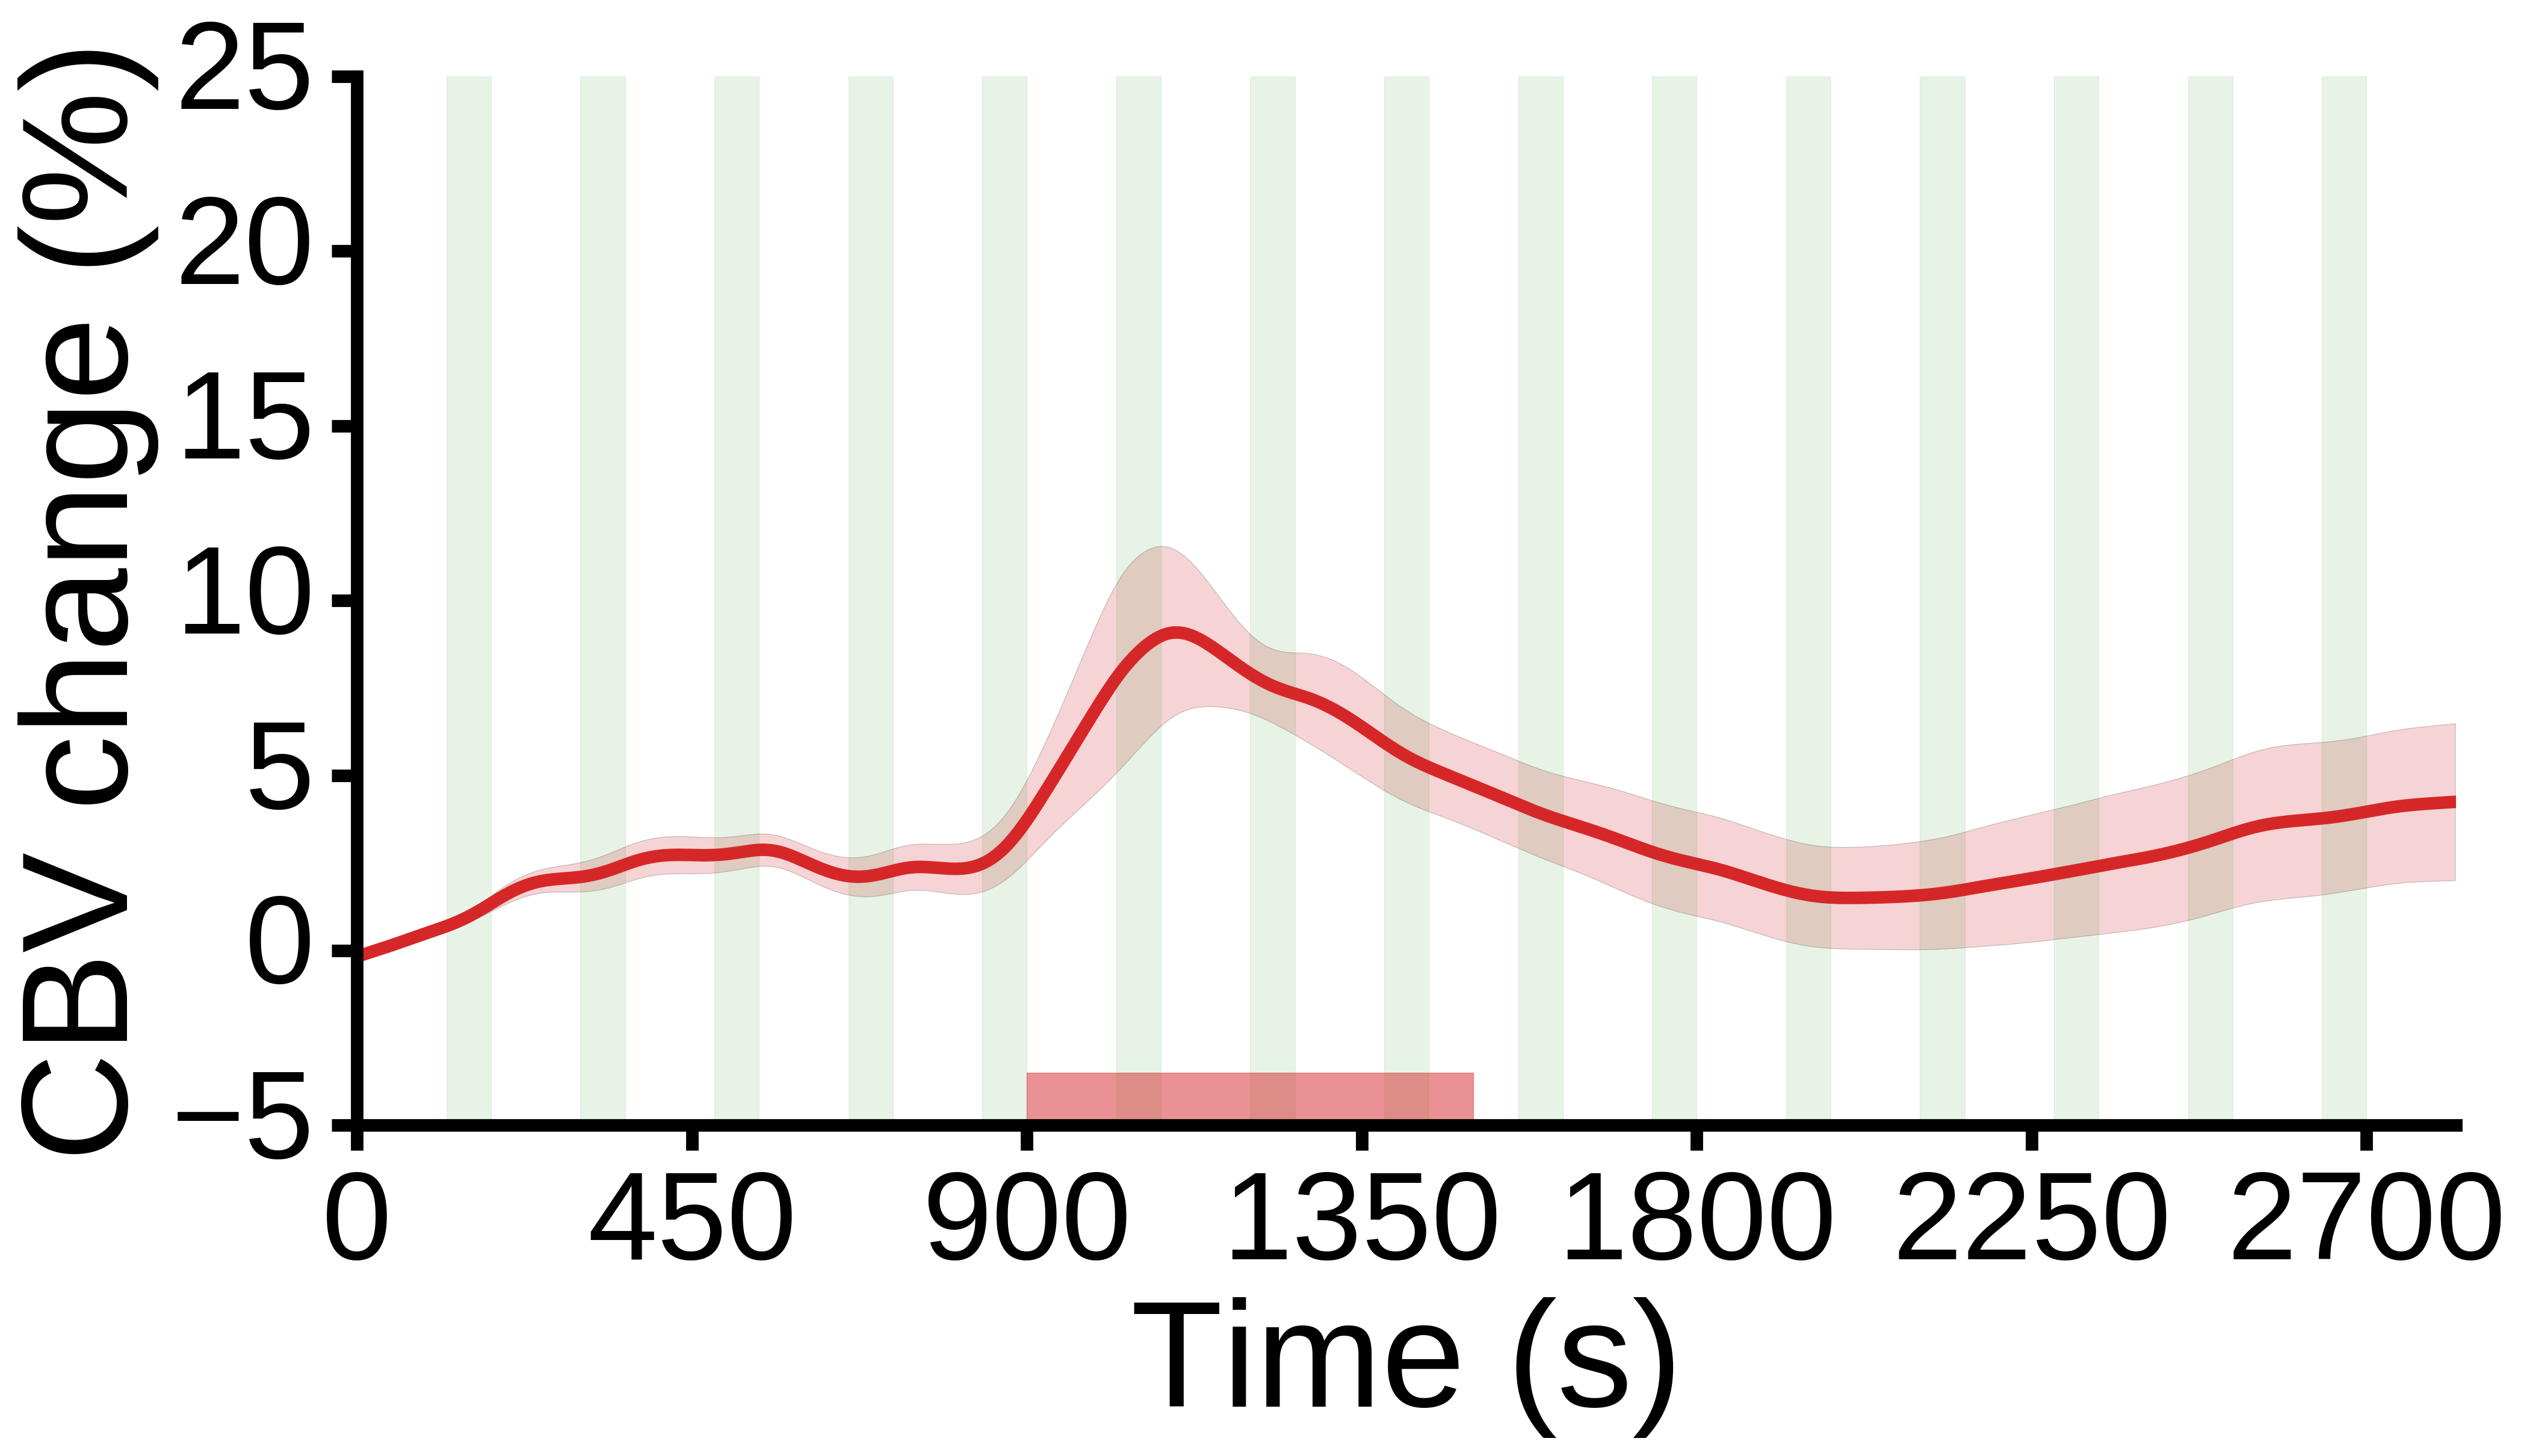

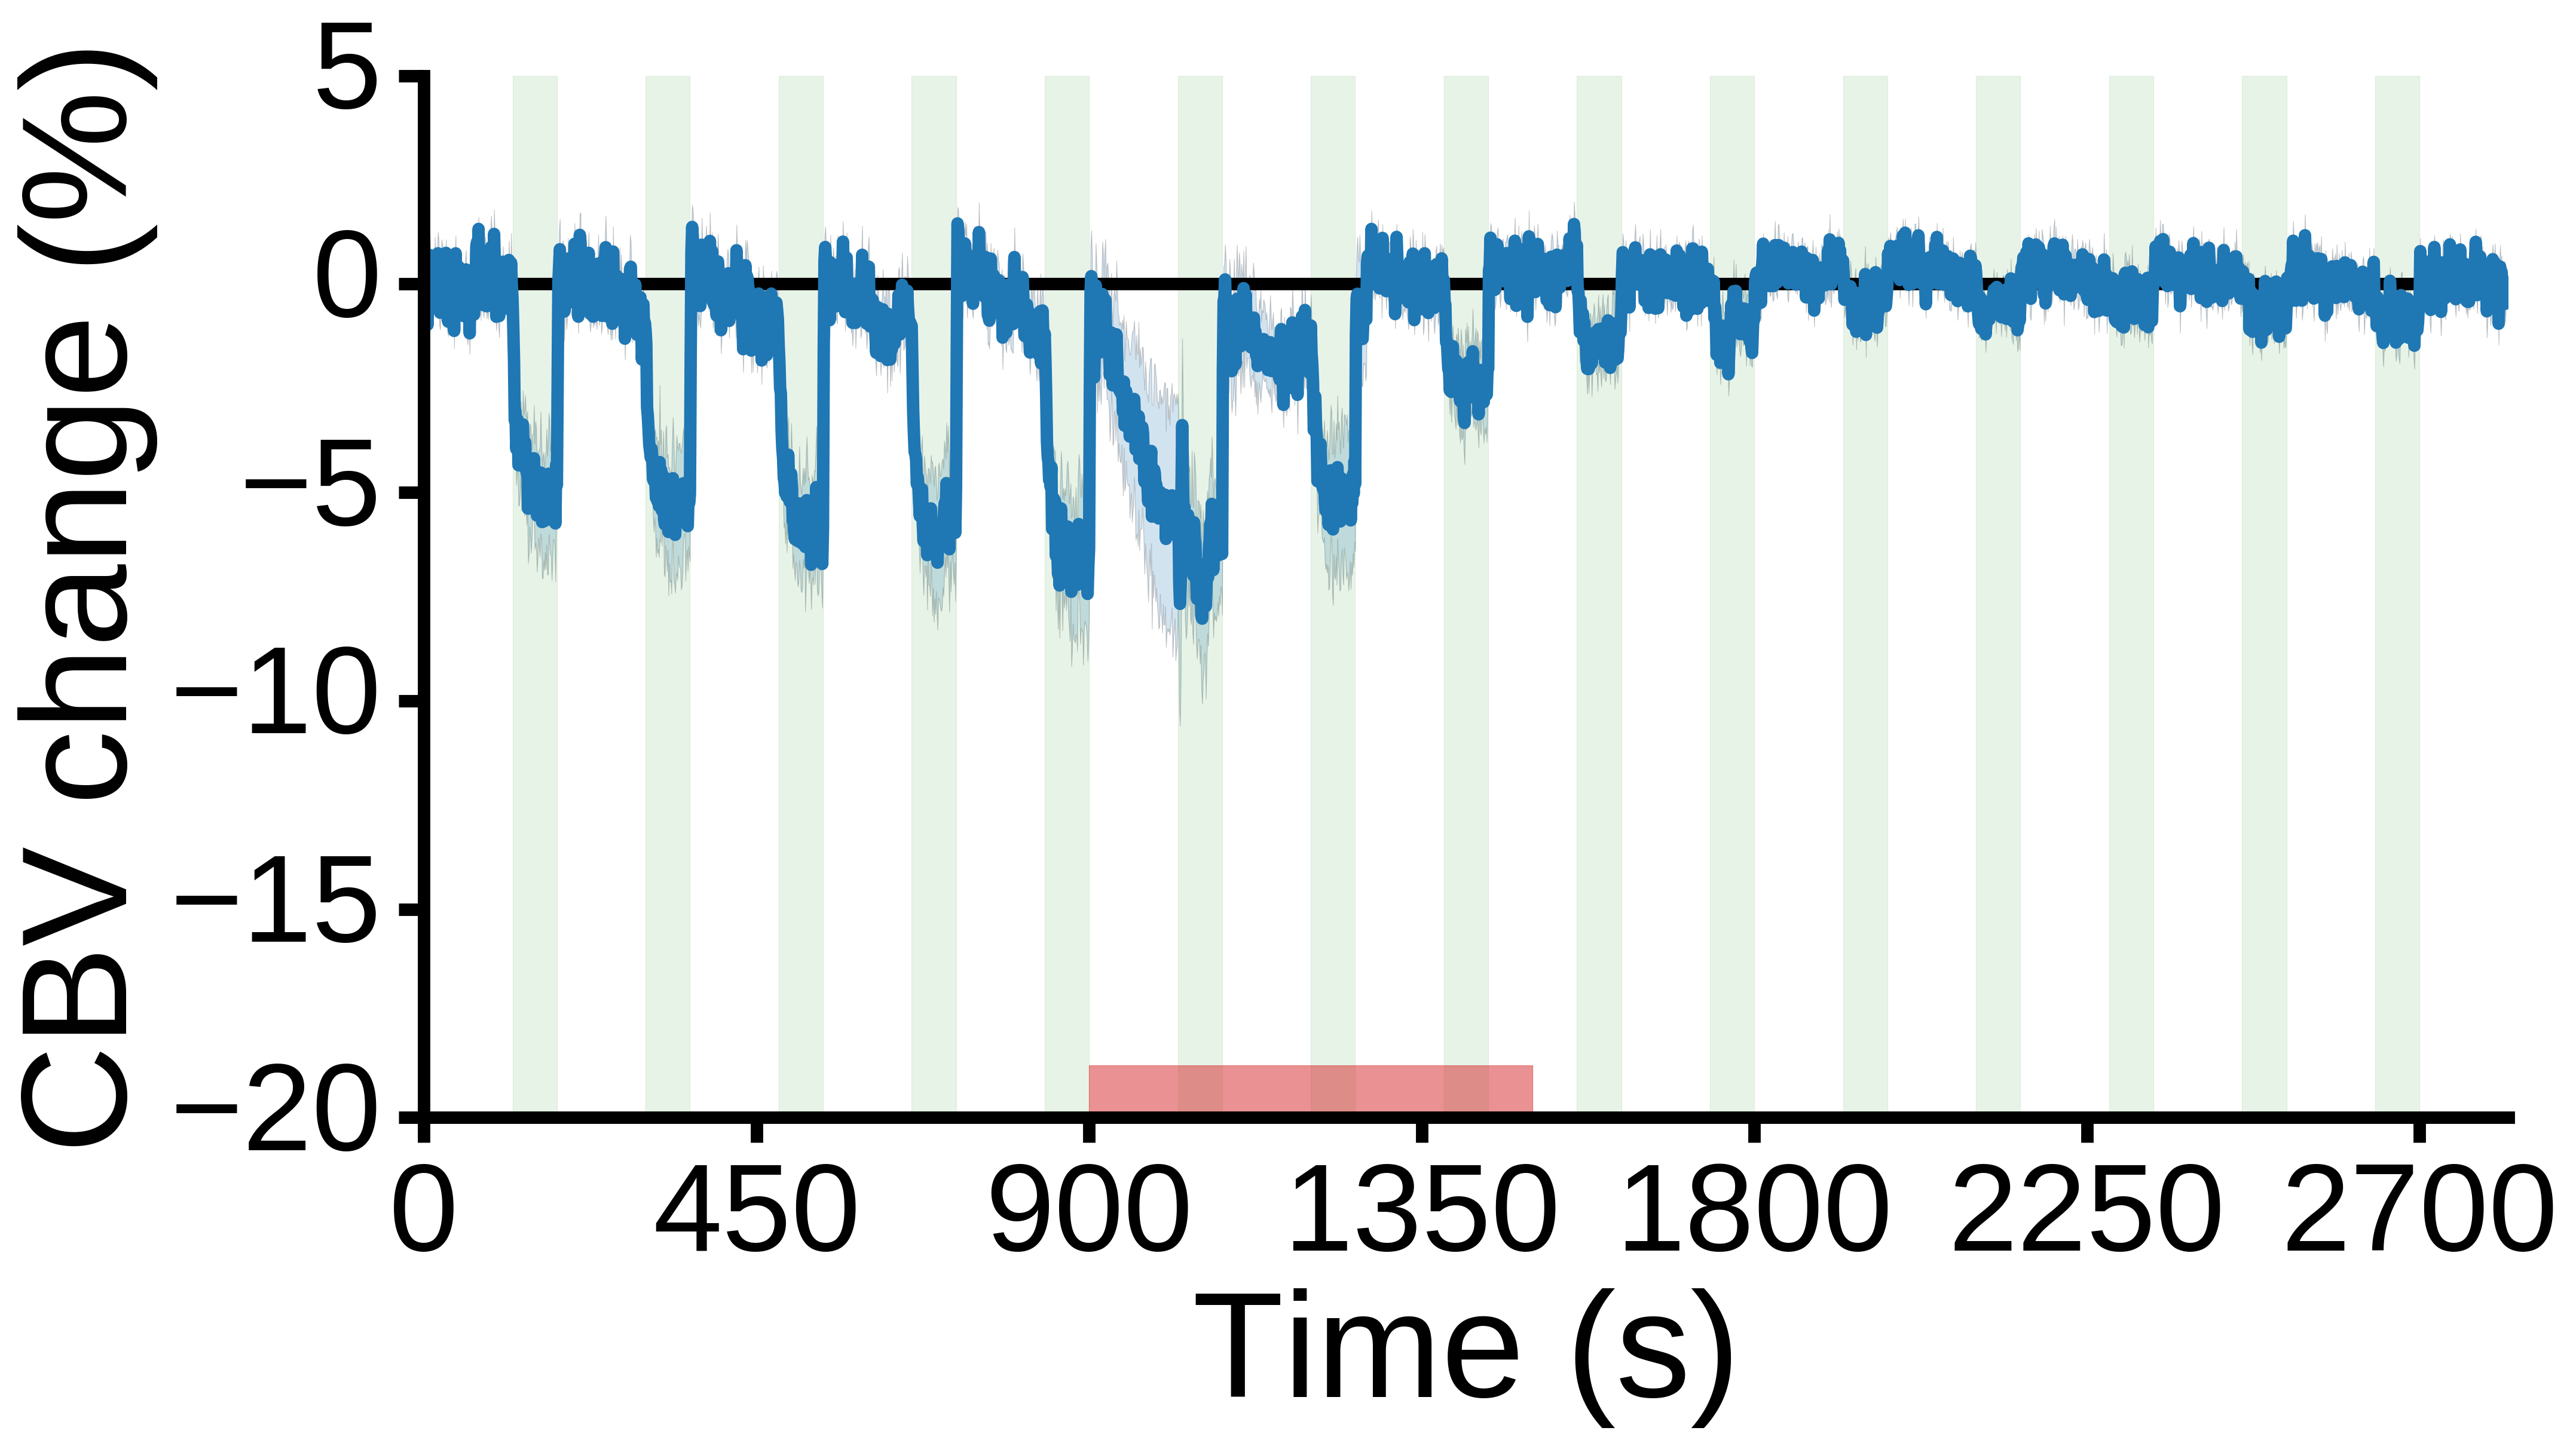

In [58]:
plot_group_data(prj, 'group-name', 'region-name')

# Next 2 functions are to cut each scan into single epochs from two different time periods (e.g. first 5 versus last 5 events) and align them for peak analysis

## adjust epoch start, end, and number (for loop range) to fit your paradigm

In [ ]:
def extract_pre(data_stim):
    epoch_data = []
    for i in range(5):

        epoch_start = 40+i*180
        epoch_end = 299+i*180
        epoch_ts = data_stim.loc[epoch_start:epoch_end, :].T.values

        epoch_data.append(epoch_ts.T)
    epoch_data = np.concatenate(epoch_data, axis=1)

    epoch_data = pd.DataFrame(epoch_data)
    return epoch_data

In [ ]:
def extract_post(data_stim):
    epoch_data = []
    for i in range(5):

        epoch_start = 1660+i*180
        epoch_end = 1919+i*180
        epoch_ts = data_stim.loc[epoch_start:epoch_end, :].T.values

        epoch_data.append(epoch_ts.T)
    epoch_data = np.concatenate(epoch_data, axis=1)

    epoch_data = pd.DataFrame(epoch_data)
    return epoch_data

# Next two functions are to get the peak values following events in the epochs cut from the first and second function above, respectively, plot these peaks values, and export the data to excel

## note that most parameters should be set when calling the function. be sure to set the ALS parameters to the same as used for the session analysis above

In [ ]:
def analyze_pre(prj, group, region, sign, stim_start, stim_end, avg_start, avg_end, lamda=20e3, p=0.9995, niter=20):
      
    data_temp = get_data_from_group(prj, group, region) 

    n_subj = data_temp.shape[-1]
    data_temp1 = pd.DataFrame(map(signal.als_detrend, data_temp.T.values, [lamda]*n_subj, [p]*n_subj, [niter]*n_subj)).T

    flatten_data(data_temp1)
    
    dfup_sub = data_temp1.iloc[0:stim_start-2]
    data1 = data_temp1 - dfup_sub.mean()
     
    data1= data1*100

    df_pre = extract_pre (data1) 

    df_post = extract_post (data1)
      
    df_pre_avg = df_pre.mean(axis=1)
    df_pre_avg = df_pre_avg*sign

    df_pre_avg = pd.DataFrame(df_pre_avg)
    df_pre_avg = df_pre_avg[0].tolist()
    
    peakloc = df_pre_avg.index(max(df_pre_avg[stim_start:stim_end]))
    
    dfup = df_pre 
    
    ax = dfup.plot(cmap='summer',legend=False, figsize= (9,9), linewidth=0.5)
    ax.set_prop_cycle(pyplot.rcParams["axes.prop_cycle"])
    newdf = DataFrame()
    
    csvdf = DataFrame(data=None, columns=['Name','PeakX', 'PeakY'])
    
    styles = {}
    count=0
    for name in dfup.columns:
        list = dfup[name].tolist();
               
        peakx=peakloc
        peaky=sum(list[peakloc+avg_start:peakloc+avg_end]) / len(list[peakloc+avg_start:peakloc+avg_end])
        
        newcol = []
        newcol = newcol + [NaN]*(dfup.count()[0]);
        
        newcol[peakx] = peaky

        newdf[int(name)] = newcol
        csvdf = csvdf.append({'Name':name, 'PeakX': peakx, 'PeakY':peaky}, ignore_index=True);

    csvdf.to_csv('{}_{}_pre.csv'.format(group, region))
    a = newdf.plot(marker= 7, color='black', legend=False, ax=ax)
    ax.add_patch(patches.Rectangle((peakloc+avg_start-0.5,-100),avg_end-avg_start+1, 200, color='b', alpha=.09))
    pyplot.show()

In [ ]:
def analyze_post(prj, group, region, sign, stim_start, stim_end, avg_start, avg_end, lamda=20e3, p=0.9995, niter=20):
      
    data_temp = get_data_from_group(prj, group, region) 

    n_subj = data_temp.shape[-1]
    data_temp1 = pd.DataFrame(map(signal.als_detrend, data_temp.T.values, [lamda]*n_subj, [p]*n_subj, [niter]*n_subj)).T

    flatten_data(data_temp1)
    
    dfup_sub = data_temp1.iloc[0:stim_start-2]
    data1 = data_temp1 - dfup_sub.mean()
     
    data1= data1*100

    df_pre = extract_pre (data1) 

    df_post = extract_post (data1)
      
    df_pre_avg = df_pre.mean(axis=1)
    df_pre_avg = df_pre_avg*sign
    df_pre_avg = pd.DataFrame(df_pre_avg)
    df_pre_avg = df_pre_avg[0].tolist()
    
    peakloc = df_pre_avg.index(max(df_pre_avg[stim_start:stim_end]))
    
    dfup = df_post 
    
    ax = dfup.plot(cmap='summer',legend=False, figsize= (9,9), linewidth=0.5)
    ax.set_prop_cycle(pyplot.rcParams["axes.prop_cycle"])
    newdf = DataFrame()
    
    csvdf = DataFrame(data=None, columns=['Name','PeakX', 'PeakY'])
    
    styles = {}
    count=0
    for name in dfup.columns:
        list = dfup[name].tolist();
               
        peakx=peakloc
        peaky=sum(list[peakloc+avg_start:peakloc+avg_end]) / len(list[peakloc+avg_start:peakloc+avg_end])
        
        newcol = []
        newcol = newcol + [NaN]*(dfup.count()[0]);
        
        newcol[peakx] = peaky

        newdf[int(name)] = newcol
        csvdf = csvdf.append({'Name':name, 'PeakX': peakx, 'PeakY':peaky}, ignore_index=True);

    csvdf.to_csv('{}_{}_post.csv'.format(group, region))
    a = newdf.plot(marker= 7, color='black', legend=False, ax=ax)
    ax.add_patch(patches.Rectangle((peakloc+avg_start-0.5,-100),avg_end-avg_start+1, 200, color='b', alpha=.09))
    pyplot.show()

# PRE

In [ ]:
analyze_pre(prj, 'group-name', 'region-name', sign = -1, stim_start = 81, stim_end = 170, avg_start = -2, avg_end = 2)

# Post

In [ ]:
analyze_post(prj, 'group-name', 'region-name', sign = -1, stim_start = 81, stim_end = 170, avg_start = -2, avg_end = 2)